In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../assets/dataset/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

store1_data = data[data.Store == 1]

data.head()

/Users/alexj/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7
2015-07-31,5,5,4822,559,1,1,0,1,2015,7


In [ ]:
data.index.year

In [3]:
import seaborn as sb
%matplotlib inline

In [4]:
data[['Sales']].resample('M').mean().sort_values(by='Sales')

,Sales
Date,
2013-01-31,5211.555578
2013-09-30,5322.988430
2013-05-31,5364.127383
2013-06-30,5402.162960
2013-10-31,5429.258788
2014-01-31,5431.875799
2015-05-31,5472.122002
2013-04-30,5483.749836
2013-02-28,5494.371397


In [ ]:
store1_data.index

We want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were any particularly interesting outliers in terms of sales or customer visits?

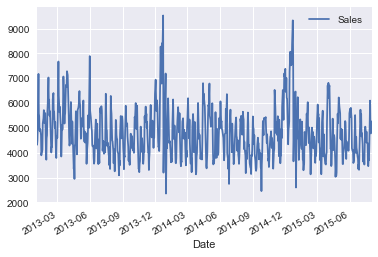

In [5]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

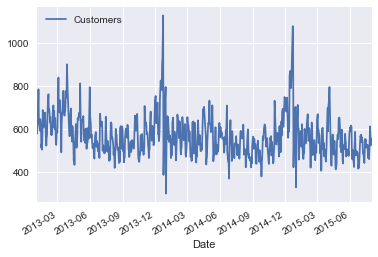

In [6]:
# To plot the customer visits over time:
store1_open_data[['Customers']].plot()

We can see that there are large spikes of sales and customers towards the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.


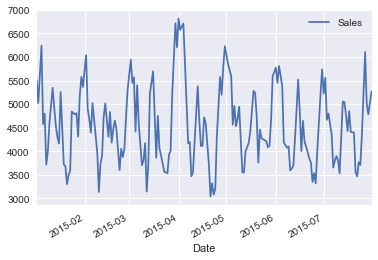

In [7]:
store1_data_2015 = store1_data['2015']
store1_data_2015[
    store1_data_2015.Open==1
][['Sales']].plot()

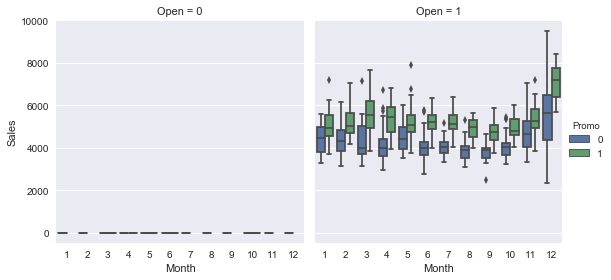

In [8]:
sb.factorplot(
    col='Open',
    hue='Promo',
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box'
)

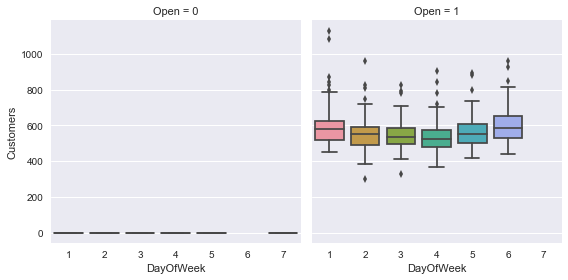

In [10]:
sb.factorplot(
    col='Open',
    x='DayOfWeek',
    y='Customers',
    data=store1_data,
    kind='box')
    


Slide 48:

## Computing Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we'll do this with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10. This computes the correlation between every point and the point 10 days earlier:


In [11]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383588

Just like with correlation between different variables, the data becomes more correlated as this number moves closer to 1.

**Check:** What does the autocorrelation values of Sales and Customers imply about our data?


## Aggregates of sales over time

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates. We want to know: what were the mean and median sales in each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - The aggregation to perform: 'mean', 'median', 'sum', etc.

In [ ]:
data[['Sales']].resample('A').apply(['median', 'mean']).head()

In [ ]:
data[['Sales']].resample('M').apply(['median', 'mean']).head()

While identifying monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare sales data in late December with the entire month, but instead to a few days immediately surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling().mean()` or `pd.rolling().median()` functions.

In [ ]:
data[['Sales']].resample('D').mean().rolling(window=3, center=True).mean().head()

This computes a rolling mean of sales using the sales on each day, the day preceding and the day following (window = 3, center=True).


`rolling` takes three important parameters:
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

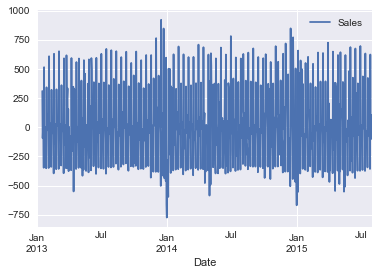

In [14]:
data[['Sales']].resample('D').mean().rolling(window=15, center=False).mean().diff(1).sort_values(by='Sales')

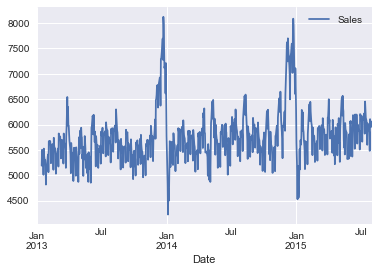

In [15]:
data[['Sales']].resample('D').mean().rolling(window=15, center=False).mean().plot()

As we discussed earlier, this averages all values in the window evenly, but we might want to weight closer values more. For example, with a centered weighted average of 10 days, we want to put additional emphasis on +/- 1 day versus +/- days. One option to do that is the `ewma` function or `exponential weighted moving average` function.


/Users/alexj/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,span=10,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


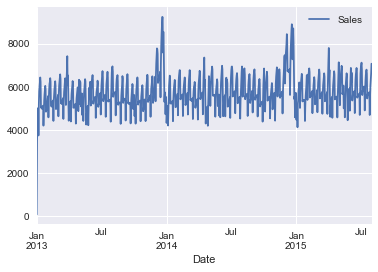

In [17]:
pd.ewma(data[['Sales']].resample('D').mean(), span=10).plot()

Pandas `rolling().mean` and `rolling().median` are only two examples of Pandas window function capabilities. Window functions operate on a set of N consecutive rows (i.e.: a window) and produce an output.

In addition to `rolling().mean` and `rolling().median`, there are `rolling().sum`, `rolling().min`, `rolling().max`... and many more.

Another common one is `diff`, which takes the difference over time. `df.diff` takes one argument: `periods`, which measures how many rows prior to use for the difference.

For example, if we want to compute the difference in sales, day by day, we could compute:


In [19]:
data[['Sales']].resample('D').mean().diff(periods=1)

,Sales
Date,
2013-01-01,NaN
2013-01-02,6145.745933
2013-01-03,-539.918386
2013-01-04,261.106726
2013-01-05,-616.467265
2013-01-06,-5208.689686
2013-01-07,9581.115695
2013-01-08,-1863.148879
2013-01-09,-899.402691


## Pandas Expanding Functions

In addition to the set of `rolling` functions, Pandas also provides a similar collection of `expanding` functions, which, instead of using a window of N values, uses all values up until that time.

For example,

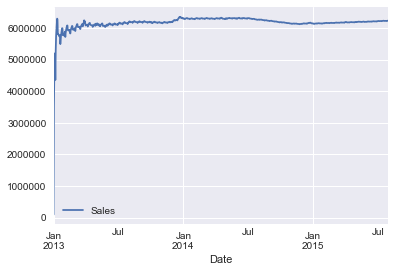

In [22]:
data[['Sales']].resample('D').sum().expanding().mean().plot()

In [ ]:
average_daily_customers = data[['Customers']].resample('D').mean()
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()

In [ ]:
average_daily_customers['DiffVsLastWeek'] = average_daily_customers.diff(periods=7)
average_daily_sales['DiffVsLastWeek'] = average_daily_sales[['Sales']].diff(periods=7)

In [ ]:
average_daily_sales[average_daily_sales.Open == 1].sort_values(by='DiffVsLastWeek')

In [ ]:
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()

In [ ]:
average_daily_sales['Sales'].autocorr(lag=1)

In [ ]:
average_daily_sales['Sales'].autocorr(lag=30)

In [ ]:
data['Sales'].resample('D').mean().expanding().mean().plot()

In [ ]:
data['2013-01-01'].Sales.sum()

In [ ]:
total_daily_sales = data[['Sales']].resample('D').sum()

total_daily_sales.expanding().sum()['2014-12']

In [ ]:
total_daily_sales.index